#1.Import Dependencies

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/AF')

In [2]:
from util import util, model_util
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np
import sklearn
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


In [3]:
import io
import itertools
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, MaxPooling2D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, GlobalAveragePooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average, GlobalAveragePooling2D, DepthwiseConv2D, ZeroPadding2D
from tensorflow.keras.initializers import glorot_uniform

#2.Input Data Pipeline

##2.1 Time-Domain

In [31]:
# load training data
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data_shift(raw_signals, raw_labels, seg_len=9000)
signals, labels = util.preprocessing(signals, labels, timedistributed=False)
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9)
#oversample labels
train_signals, train_labels = util.oversample_labels(train_signals, train_labels)
val_signals, val_labels = util.oversample_labels(val_signals, val_labels)

print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (56058, 3000, 1)
train_label shape: (56058,)

In training data:
There are 18686 NSR labels
There are 18686 AF labels
There are 18686 Other Arrhythmia labels

In validation data:
There are 2053 NSR labels
There are 2053 AF labels
There are 2053 Other Arrhythmia labels


(2053, 2053, 2053)

In [59]:
# load testing data
test_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/validation/"
test_raw_signals, test_raw_labels = util.data_mining(test_data_file_path)
test_signals, test_labels = util.generate_seg_data(test_raw_signals, test_raw_labels, seg_len=9000)
test_signals, test_labels = util.preprocessing(test_signals, test_labels, timedistributed=False)
print('test_signal shape:', test_signals.shape)
print('test_label shape:', test_labels.shape)
print("\nIn test data:") 
util.count_labels(test_labels)

test_signal shape: (276, 3000, 1)
test_label shape: (276, 1)

In test data:
There are 150 NSR labels
There are 47 AF labels
There are 79 Other Arrhythmia labels


(150, 47, 79)

In [33]:
#convert test labels to floating point type, so that it can be compared with model output
test_labels = test_labels.flatten()
test_labels = test_labels.astype(int)
type(test_labels[0])

numpy.int32

In [ ]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
## loading
batch_size = 128
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

##2.2 Freq-Domain

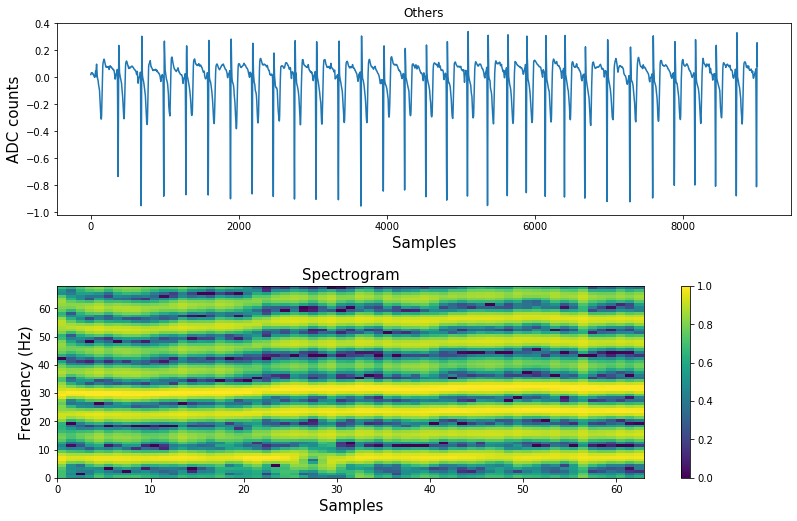

Spectrom shape: (68, 63, 1)
Label shape: (1,)


In [66]:
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data_shift(raw_signals, raw_labels, seg_len=9000)
#sanity check
util.plot_spectrogram(signals, labels, 2)
print('Spectrom shape:', util.get_spectrogram_and_label(signals[0], labels[0])[0].shape)
print('Label shape:', util.get_spectrogram_and_label(signals[0], labels[0])[1].shape)

In [67]:
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9, seed=10)
print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (35537, 9000)
train_label shape: (35537, 1)

In training data:
There are 18686 NSR labels
There are 3325 AF labels
There are 13526 Other Arrhythmia labels

In validation data:
There are 2053 NSR labels
There are 386 AF labels
There are 1510 Other Arrhythmia labels


(2053, 386, 1510)

In [68]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
train_dataset = train_dataset.map(util.get_spectrogram_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(util.get_spectrogram_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## loading
batch_size = 128
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

In [69]:
#process validation data for tensorboard
val_spectrogram = []
for val_signal in val_signals:
  val_spectrogram.append(util.get_spectrogram(val_signal))

val_signals = np.array(val_spectrogram)
val_signals = tf.expand_dims(val_signals, -1)
val_signals.shape

TensorShape([3949, 68, 63, 1])

In [70]:
# load testing data
test_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/validation/"
test_raw_signals, test_raw_labels = util.data_mining(test_data_file_path)
test_signals, test_labels = util.generate_seg_data(test_raw_signals, test_raw_labels, seg_len=9000)
print('test_signal shape:', test_signals.shape)
print('test_label shape:', test_labels.shape)
print("\nIn test data:") 
util.count_labels(test_labels)

test_signal shape: (276, 9000)
test_label shape: (276, 1)

In test data:
There are 150 NSR labels
There are 47 AF labels
There are 79 Other Arrhythmia labels


(150, 47, 79)

In [71]:
# Process test signals for model evaluation
test_spectrogram = []
for test_signal in test_signals:
  test_spectrogram.append(util.get_spectrogram(test_signal))

test_signals = np.array(test_spectrogram)
test_signals = tf.expand_dims(test_signals, -1)
test_signals.shape

TensorShape([276, 68, 63, 1])

##2.3. Time-Domain and Freq-Domain

In [4]:
# load training data
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)
print(f"There are {signals.shape[0]} 30s samples")

There are 8250 30s samples


###Prepare time-domain data

In [5]:
t_signals, t_labels = util.preprocessing(signals, labels, timedistributed=False)
t_train_signals, t_train_labels, t_val_signals, t_val_labels = util.split_shuffle_dataset(t_signals, t_labels, 0.9, seed=10)
#oversample labels
t_train_signals, t_train_labels = util.oversample_labels(t_train_signals, t_train_labels)
t_val_signals, t_val_labels = util.oversample_labels(t_val_signals, t_val_labels)

print(f't_train_signal shape: {t_train_signals.shape}')
print(f't_train_label shape: {t_train_labels.shape}')
print("\nIn training data:") 
util.count_labels(t_train_labels)
print("\nIn validation data:")
util.count_labels(t_val_labels)

t_train_signal shape: (13290, 3000, 1)
t_train_label shape: (13290,)

In training data:
There are 4430 NSR labels
There are 4430 AF labels
There are 4430 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 502 AF labels
There are 502 Other Arrhythmia labels


(502, 502, 502)

###Prepare frequency-domain data

In [6]:
f_train_signals, f_train_labels, f_val_signals, f_val_labels = util.split_shuffle_dataset(signals, labels, 0.9, seed=10)
#oversample labels
f_train_signals, f_train_labels = util.oversample_labels(f_train_signals, f_train_labels)
f_val_signals, f_val_labels = util.oversample_labels(f_val_signals, f_val_labels)
print(f'f_train_signal shape: {f_train_signals.shape}')
print(f'f_train_label shape: {f_train_labels.shape}')
print("\nIn training data:") 
util.count_labels(f_train_labels)
print("\nIn validation data:")
util.count_labels(f_val_labels)

f_train_signal shape: (13290, 9000)
f_train_label shape: (13290,)

In training data:
There are 4430 NSR labels
There are 4430 AF labels
There are 4430 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 502 AF labels
There are 502 Other Arrhythmia labels


(502, 502, 502)

In [7]:
#make sure labels in time and frequency are the same
assert np.all(t_train_labels == f_train_labels)

###Prepare validation for tensorboard

In [8]:
#process validation data for tensorboard
f_val_spectrogram = []
for val_signal in f_val_signals:
  f_val_spectrogram.append(util.get_spectrogram(val_signal))

f_val_signals_spectrum = np.array(f_val_spectrogram)
f_val_signals_spectrum = np.expand_dims(f_val_signals_spectrum, -1)

In [9]:
val_signals = [t_val_signals, f_val_signals_spectrum]
val_labels = f_val_labels

###Prepare test data for evaluation

In [10]:
# load testing data
test_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/validation/"
test_raw_signals, test_raw_labels = util.data_mining(test_data_file_path)
test_signals, test_labels = util.generate_seg_data(test_raw_signals, test_raw_labels, seg_len=9000)
print('test_signal shape:', test_signals.shape)
print('test_label shape:', test_labels.shape)
print("\nIn test data:") 
util.count_labels(test_labels)

test_signal shape: (276, 9000)
test_label shape: (276, 1)

In test data:
There are 150 NSR labels
There are 47 AF labels
There are 79 Other Arrhythmia labels


(150, 47, 79)

In [11]:
t_test_signals, t_test_labels = util.preprocessing(test_signals, test_labels, timedistributed=False)

In [12]:
# Process test signals for model evaluation
f_test_spectrogram = []
for test_signal in test_signals:
  f_test_spectrogram.append(util.get_spectrogram(test_signal))

f_test_signals = np.array(f_test_spectrogram)
f_test_signals = tf.expand_dims(f_test_signals, -1)

In [13]:
test_signals = [t_test_signals, f_test_signals]

###TF pipeline

In [14]:
#time domain
t_train_dataset = tf.data.Dataset.from_tensor_slices(t_train_signals)
t_val_dataset = tf.data.Dataset.from_tensor_slices(t_val_signals)

#freq domain
f_train_dataset = tf.data.Dataset.from_tensor_slices(f_train_signals)
f_val_dataset = tf.data.Dataset.from_tensor_slices(f_val_signals)
f_train_dataset = f_train_dataset.map(util.get_spectrogram_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
f_val_dataset = f_val_dataset.map(util.get_spectrogram_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#label
train_lb = tf.data.Dataset.from_tensor_slices(t_train_labels)
val_lb = tf.data.Dataset.from_tensor_slices(t_val_labels)

train = tf.data.Dataset.zip(((t_train_dataset, f_train_dataset), train_lb))
validation = tf.data.Dataset.zip(((t_val_dataset, f_val_dataset), val_lb))

## loading
batch_size = 128
train_dataset = train.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = validation.repeat().batch(batch_size, drop_remainder=True)

#3.Model

##3.1.Training with Time-Domain

###Short CNN-1D

In [37]:
model = model_util.simple_cnn_1d((3000, 1), dropout=0.2, classes=3)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

Model: "cnn_1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3000, 1)]         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3000, 8)           16        
_________________________________________________________________
batch_normalization_6 (Batch (None, 3000, 8)           32        
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1500, 8)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1500, 8)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1498, 16)          400       
_________________________________________________________________
batch_normalization_7 (Batch (None, 1498, 16)          64   

###MobileNet-1D

In [ ]:
model = model_util.MobileNet_1D(input_shape=(3000,1), dropout=0.5, classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

###ResNet-1D

In [ ]:
#cnn + lstm model
model = model_util.resnet18_1d((3000,1), classes=3, as_model=True)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

##3.2 Training with Freq-Domain

###Short CNN

In [72]:
model = model_util.simple_cnn(input_shape=(68,63,1), dropout=0.2, classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 68, 63, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 68, 63, 8)         16        
_________________________________________________________________
batch_normalization_34 (Batc (None, 68, 63, 8)         32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 31, 8)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 29, 16)        1168      
_________________________________________________________________
batch_normalization_35 (Batc (None, 32, 29, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 28, 16)        0       

###MobileNet

In [55]:
model = model_util.MobileNet(input_shape=(68,63,1), dropout=0.5, alpha=1, classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 68, 63, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 32, 32)        288       
_________________________________________________________________
batch_normalization_17 (Batc (None, 34, 32, 32)        128       
_________________________________________________________________
activation_67 (Activation)   (None, 34, 32, 32)        0         
_________________________________________________________________
depthwise_conv2d_8 (Depthwis (None, 34, 32, 32)        288       
_________________________________________________________________
batch_normalization_18 (Batc (None, 34, 32, 32)        128       
_________________________________________________________________
activation_68 (Activation)   (None, 34, 32, 32)        0 

###Resnet-18

In [ ]:
model = model_util.resnet18(input_shape=(68,63,1), classes=3, as_model=True)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

##3.3 Training with both time-domain and frequency-domain

###Mutilple input model


###CNN

In [35]:
def time_freq_model(input_shape=None, classes=3, dropout=0.2):
  time_input = Input(shape = (3000, 1))
  freq_input = Input(shape = (68, 63, 1))

  x_t = model_util.simple_cnn_1d(input_shape=(3000,1), dropout=dropout, is_model=False)(time_input)
  x_f = model_util.simple_cnn(input_shape=(68, 63, 1), dropout=dropout, is_model=False)(freq_input)

  x = Concatenate(axis=-1)([x_t, x_f])
  output = Dense(classes, activation='softmax')(x)
  model = Model(inputs = (time_input, freq_input), outputs = output)
  return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 68, 63, 1)]  0                                            
__________________________________________________________________________________________________
cnn_1d_layer (Functional)       (None, 64)           199536      input_1[0][0]                    
__________________________________________________________________________________________________
cnn_layer (Functional)          (None, 64)           589360      input_2[0][0]                    
_______________________________________________________________________________________

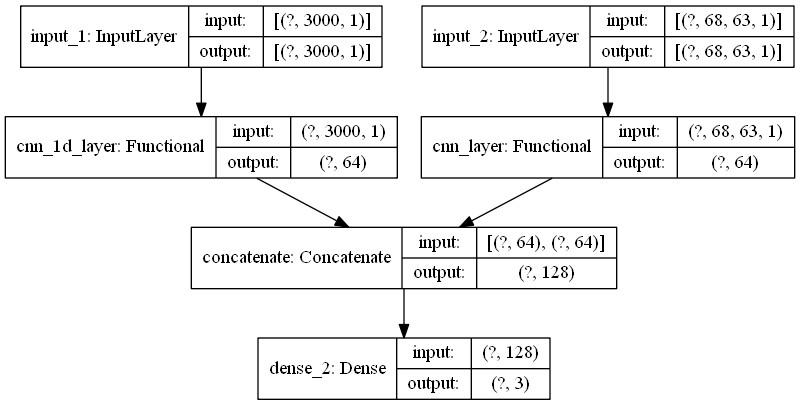

In [36]:
model = time_freq_model(classes=3, dropout=0.5)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, "C:/Users/57lzhang.US04WW4008/Desktop/multi_input_and_output_model.png", show_shapes=True)

###Moible

In [15]:
def time_freq_model(input_shape=None, classes=3, dropout=0.2):
  time_input = Input(shape = (3000, 1))
  freq_input = Input(shape = (68, 63, 1))

  x_t = model_util.MobileNet_1D(input_shape=(3000,1), dropout=dropout, is_model=False)(time_input)
  x_f = model_util.MobileNet(input_shape=(68, 63, 1), dropout=dropout, is_model=False)(freq_input)

  x = Concatenate(axis=-1)([x_t, x_f])
  output = Dense(classes, activation='softmax')(x)
  model = Model(inputs = (time_input, freq_input), outputs = output)
  return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 68, 63, 1)]  0                                            
__________________________________________________________________________________________________
mobilenet_1d (Functional)       (None, 64)           1925056     input_1[0][0]                    
__________________________________________________________________________________________________
mobilenet (Functional)          (None, 64)           1939648     input_2[0][0]                    
_______________________________________________________________________________________

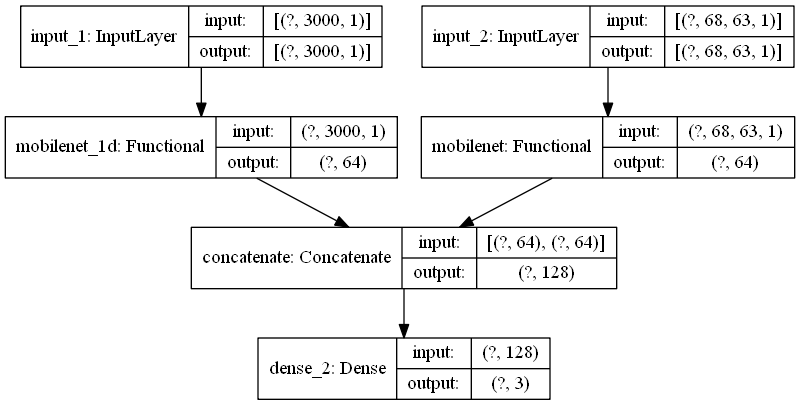

In [16]:
model = time_freq_model(classes=3, dropout=0.5)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, "C:/Users/57lzhang.US04WW4008/Desktop/multi_input_and_output_model.png", show_shapes=True)

###ResNet

In [15]:
def time_freq_model(input_shape=None, classes=3, dropout=0.2):
  time_input = Input(shape = (3000, 1))
  freq_input = Input(shape = (68, 63, 1))

  x_t = model_util.resnet18_1d(input_shape=(3000,1), classes=3, as_model=False)(time_input)
  x_f = model_util.resnet18(input_shape=(68, 63, 1), classes=3, as_model=False)(freq_input)

  x = Concatenate(axis=-1)([x_t, x_f])
  output = Dense(classes, activation='softmax')(x)
  model = Model(inputs = (time_input, freq_input), outputs = output)
  return model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3000, 1)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 68, 63, 1)]  0                                            
__________________________________________________________________________________________________
ResNet18_1d (Functional)        (None, 23552)        4202368     input_1[0][0]                    
__________________________________________________________________________________________________
ResNet18 (Functional)           (None, 512)          12542284    input_2[0][0]                    
_______________________________________________________________________________________

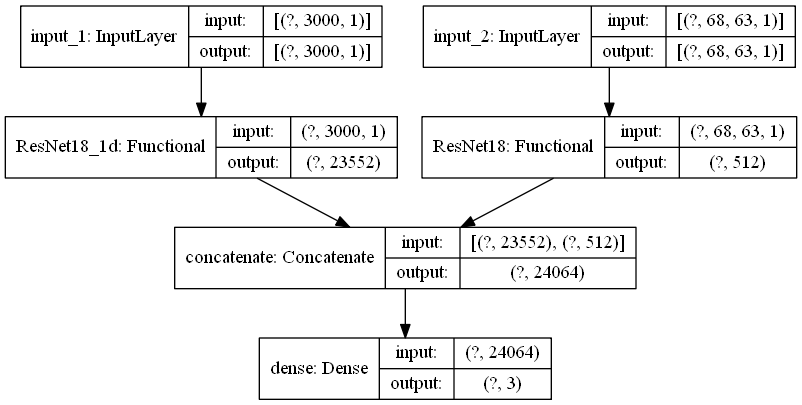

In [16]:
model = time_freq_model(classes=3, dropout=0.5)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, "C:/Users/57lzhang.US04WW4008/Desktop/multi_input_and_output_model.png", show_shapes=True)

##3.4 Training with Autoencoder

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average

In [ ]:
import os
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models")
ecg_encoder = tf.keras.models.load_model('ECG_Encoder.h5')
conv_encoder_clone = tf.keras.models.clone_model(ecg_encoder)

In [ ]:
def encoder_lstm(input_shape=(3,1250,1), classes=3):
  X_input = Input(shape=input_shape)
  X = TimeDistributed(conv_encoder_clone)(X_input)
  X = TimeDistributed(Flatten())(X)
  X = Bidirectional(LSTM(32, return_sequences=True))(X)
  X = Bidirectional(LSTM(16))(X)
  X = Dense(classes, activation='softmax')(X)

  model = Model(inputs=[X_input], outputs=X)

  return model

In [ ]:
model = encoder_lstm(input_shape=(3,1250,1), classes=3)

In [ ]:
model.summary()

In [ ]:
conv_encoder_clone.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

#4.Callbacks

In [17]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "mobile-f+t-noshift-300Hz"

## confusion matrix callback
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    
    test_pred_raw = model.predict(val_signals)

    test_pred = np.argmax(test_pred_raw, axis=1)
    test_labels = val_labels.reshape([len(t_val_labels)])
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)
    cm_image = model_util.plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

class_names = ['NSR','Afib','Others']
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\mobile-f+t-noshift-300Hz-{epoch:02d}-{loss:.4f}"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

## early stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, early_stop, lr_schedule]

#5.Model Training

In [18]:
#model training
model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(t_train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(t_val_signals))//batch_size,
          callbacks=callbacks_list)

Epoch 1/200
  1/103 [..............................] - ETA: 0s - loss: 1.3415 - accuracy: 0.2578WARNING:tensorflow:From C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
103/103 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.7252
Epoch 00001: val_loss improved from inf to 1.15722, saving model to C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\mobile-f+t-noshift-300Hz-01-0.5963
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\mobile-f+t-noshift-300Hz-01-0.596

#6.Model Evaluation

In [4]:
model = tf.keras.models.load_model(r'C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-f+t-shift-300Hz-16-0.0342')

In [39]:
test_pred_raw = model.predict(test_signals)
test_pred = np.argmax(test_pred_raw, axis=1)

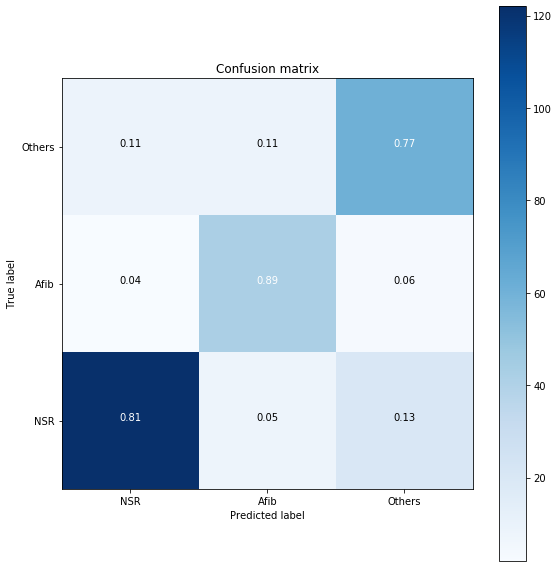

In [40]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)

In [41]:
sklearn.metrics.accuracy_score(t_test_labels, test_pred)

0.8152173913043478

In [42]:
sklearn.metrics.f1_score(t_test_labels, test_pred, average='weighted')

0.8177635481261715